In [24]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [25]:
# Define main path to dataset
main_path = '/kaggle/input/d/xhlulu/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')


In [26]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [27]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [28]:
images_df = pd.DataFrame(images_df)

In [29]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [30]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [31]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [32]:
# Data Augmentation
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    zoom_range=0.4,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    fill_mode='nearest'
)


image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [33]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


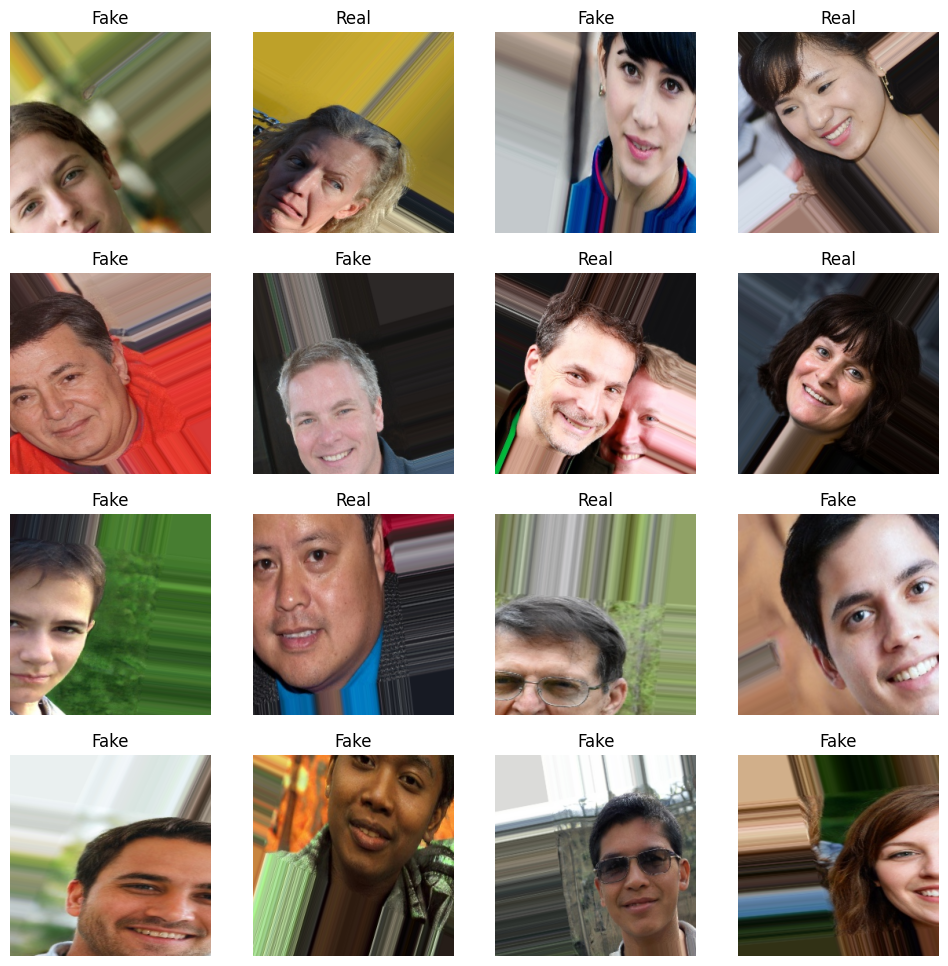

In [34]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")
img,lbl = next(train_ds)
plot_images(img,lbl)

In [35]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  ...
  [0.4267627  0.41960788 0.4214646 ]
  [0.42670378 0.4227822  0.41017756]
  [0.43385866 0.4324231  0.4053571 ]]

 [[0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  ...
  [0.42674166 0.41960788 0.4214014 ]
  [0.42674592 0.42282435 0.4101565 ]
  [0.4338797  0.43246529 0.40533602]]

 [[0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  [0.64705884 0.654902   0.63529414]
  ...
  [0.4267206  0.41960788 0.42133817]
  [0.42678806 0.4228665  0.41013542]
  [0.43390077 0.4325074  0.40531495]]

 ...

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.22386314 0.2217367  0.23595917]
  [0.22543187 0.22484297 0.2344528 ]
  [0.20880681 0.20758545 0.21726686]]

 [[0.00423751 0.00423751 0.00423751]
  [0.00421365 0.00421365 0.0

In [36]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [37]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [39]:
# Assuming the uploaded weights file is located in '/kaggle/input/efficientnetb0-weights'
local_weights_path = '/kaggle/input/weights/efficientnetb0_notop.h5'

In [40]:
# Load EfficientNetB0 model with local weights and include_top=False
efficientnet_b0 = EfficientNetB0(weights=local_weights_path, include_top=False, input_shape=(256, 256, 3))

In [41]:
# Make EfficientNetB0 layers trainable
efficientnet_b0.trainable = True

In [42]:
# Make EfficientNetB0 layers trainable
efficientnet_b0.trainable = True

# Custom CNN layers with Batch Normalization and L2 regularization
custom_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
])

# Add the custom CNN architecture to EfficientNetB0
x = efficientnet_b0.output
x = custom_cnn(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the hybrid model
hybrid_model = Model(inputs=efficientnet_b0.input, outputs=x)

# Compile the model with a reduced learning rate
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the hybrid model
hybrid_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 6,737,252 (25.70 MB)

 Trainable params: 6,691,773 (25.53 MB)

 Non-trainable params: 45,479 (177.66 KB)

In [43]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True
)

In [44]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=3,
                                                     restore_best_weights=True,
                                                    )

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [46]:
history = hybrid_model.fit(train_ds,
                       epochs 
                           
                           = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1732s 1s/step - accuracy: 0.5610 - loss: 2.1965 - val_accuracy: 0.7459 - val_loss: 1.7952 - learning_rate: 1.0000e-04
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1585s 1s/step - accuracy: 0.8724 - loss: 1.4459 - val_accuracy: 0.9498 - val_loss: 1.1996 - learning_rate: 1.0000e-04
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1591s 1s/step - accuracy: 0.9364 - loss: 1.1341 - val_accuracy: 0.9867 - val_loss: 0.8468 - learning_rate: 1.0000e-04
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1583s 1s/step - accuracy: 0.9549 - loss: 0.8522 - val_accuracy: 0.9920 - val_loss: 0.5799 - learning_rate: 1.0000e-04
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1588s 1s/step - accuracy: 0.9687 - loss: 0.5771 - val_accuracy: 0.9922 - val_loss: 0.3682 - learning_rate: 1.0000e-04
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1596s 1s/step - accuracy: 0.9733 - loss: 0.3756 - val_accuracy: 0.9955 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1603s 1s/

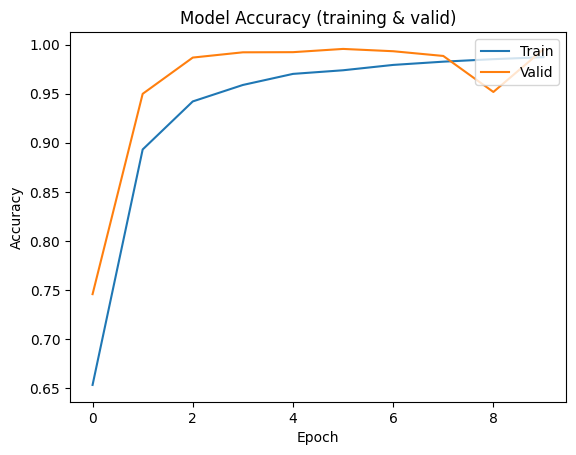

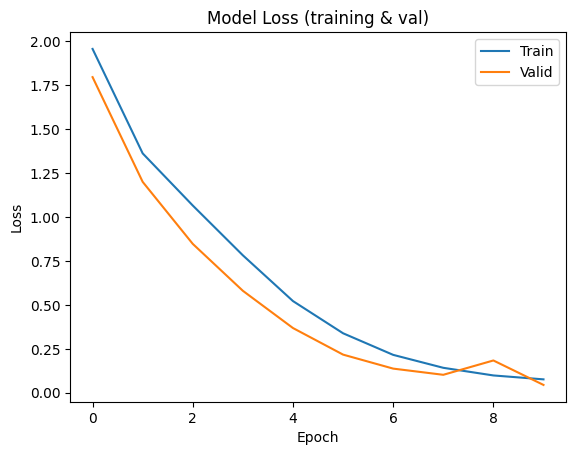

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [48]:
# Evaluate the model on the test set
test_loss, test_acc = hybrid_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 463ms/step - accuracy: 0.9971 - loss: 0.0393
Test Loss: 0.047564975917339325
Test Accuracy: 0.994700014591217
